### ライブラリのインポート

In [1]:
import numpy as np
import pyconll
import torch

from pqgrams.PQGram import Profile

from scripts import w_pq_batch as w_pq
from scripts import trees, pq_gram

import random

from tqdm.notebook import tqdm_notebook as tqdm
from tqdm.notebook import trange

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def calculate_radius(distance_matrix):
    """
    距離行列から集合の半径を計算する関数
    :param distance_matrix: 2次元 NumPy 配列 (距離行列)
    :return: 半径 (float)
    """
    # 距離行列の各行の最大値を取得（点から他の点への最大距離）
    max_distances = np.max(distance_matrix, axis=1)
    
    # 最大距離の中での最小値を取得（最適な中心を選ぶ）
    radius = np.min(max_distances)
    
    return radius

# 距離行列の例
distance_matrix = np.array([
    [0, 2, 3, 7],
    [2, 0, 4, 6],
    [3, 4, 0, 5],
    [7, 6, 5, 0]
])

# 半径を計算
radius = calculate_radius(distance_matrix)
print(f"集合の半径: {radius}")


集合の半径: 5


In [3]:
CoNLL= pyconll.load_from_file("corpora/English/English-EWT.conllu")
CoNLL = random.sample(CoNLL, len(CoNLL))

pqtrees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLL]
pqindex = [Profile(tree, p=2, q=2) for tree in pqtrees]


J = set(pqindex[0])
for pq_set in pqindex[1:]:
    J = J.union(pq_set)
J = list(J)

tensors = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(pqindex, desc="[convert tensor]")]


[convert tensor]:   0%|          | 0/16621 [00:00<?, ?it/s]

In [4]:
def calculate_radius_torch(distance_matrix):
    """
    距離行列から集合の半径を計算する関数 (PyTorch)
    :param distance_matrix: 2次元 torch.Tensor (距離行列)
    :return: 半径 (float)
    """
    # 距離行列の各行の最大値を取得（点から他の点への最大距離）
    max_distances = torch.max(distance_matrix, dim=1).values
    
    # 最大距離の中での最小値を取得（最適な中心を選ぶ）
    radius = torch.min(max_distances)
    
    return radius.item()  # Pythonのfloatとして返す

# 距離行列の例 (torch.Tensor)
distance_matrix = torch.tensor([
    [0, 2, 3, 7],
    [2, 0, 4, 6],
    [3, 4, 0, 5],
    [7, 6, 5, 0]
], dtype=torch.float)

# 半径を計算
radius = calculate_radius_torch(distance_matrix)
print(f"集合の半径: {radius}")

集合の半径: 5.0


In [5]:
def add_point_to_distance_matrix(distance_matrix: torch.Tensor, new_distances: torch.Tensor):
    """
    距離行列に新しい行と列を追加する関数
    :param distance_matrix: 現在の距離行列 (torch.Tensor)
    :param new_distances: 新しい点から既存の点への距離リスト (torch.Tensor)
    :return: 拡張された距離行列 (torch.Tensor)
    """
    # 入力の検証
    assert len(new_distances) == distance_matrix.size(0), "新しい点の距離数が既存の点数と一致しません。"
    assert distance_matrix.device == new_distances.device

    device = new_distances.device

    # 既存の行列に新しい行を追加する (新しい点への距離)
    new_row = torch.cat([new_distances, torch.tensor([0.0], device=device)], dim=0).unsqueeze(0)  # 行ベクトル
    
    # 新しい列を作成する (新しい点から他の点への距離)
    new_col = torch.cat([new_distances, torch.tensor([0.0], device=device)], dim=0).unsqueeze(1)  # 列ベクトル
    
    # 行列の右側に新しい列を追加
    expanded_matrix = torch.cat([distance_matrix, new_col[:-1]], dim=1)
    
    # 行列の下側に新しい行を追加
    expanded_matrix = torch.cat([expanded_matrix, new_row], dim=0)
    
    return expanded_matrix


In [6]:
dimension = tensors[0].size()
distance_matrix = w_pq.distance_matrix(tensors, torch.ones(dimension))

In [7]:
radius = calculate_radius_torch(distance_matrix)
radius

212.74838256835938

In [24]:
len(tensors)

16621

In [ ]:
rad_list = []
x = []

for i in trange(1, 16621):
    k = i
    x.append(k)
    rad = calculate_radius_torch(distance_matrix[:k, :k])
    rad_list.append(rad)

x.append(len(tensors))
rad_list.append(calculate_radius_torch(distance_matrix))
rad_list

  0%|          | 0/16620 [00:00<?, ?it/s]

[0.0,
 28.891756057739258,
 18.385662078857422,
 18.385662078857422,
 18.385662078857422,
 18.385662078857422,
 18.385662078857422,
 15.759140014648438,
 60.4100341796875,
 60.4100341796875,
 60.4100341796875,
 91.92831420898438,
 91.92831420898438,
 91.92831420898438,
 91.92831420898438,
 76.16917419433594,
 76.16917419433594,
 76.16917419433594,
 81.42222595214844,
 81.42222595214844,
 81.42222595214844,
 81.42222595214844,
 81.42222595214844,
 81.42222595214844,
 81.42222595214844,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.542648

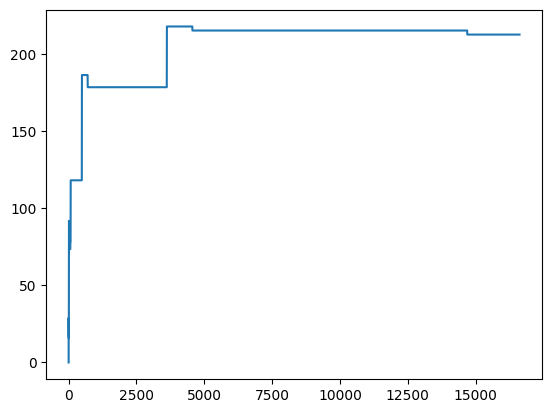

In [41]:
fig, ax = plt.subplots()
ax.plot(x, rad_list)

In [8]:
CoNLL= pyconll.load_from_file("corpora/English/English-EWT.conllu")
CoNLL = random.sample(CoNLL, len(CoNLL))

pqtrees = [trees.conllTree_to_pqTree_upos(conll.to_tree()) for conll in CoNLL]
pqindex = [Profile(tree, p=2, q=2) for tree in pqtrees]


J = set(pqindex[0])
for pq_set in pqindex[1:]:
    J = J.union(pq_set)
J = list(J)

tensors = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(pqindex, desc="[convert tensor]")]
dimension = tensors[0].size()
tensors = torch.stack([t.to("cuda:2") for t in tensors])
distance_matrix = w_pq.distance_matrix(tensors, torch.ones(dimension))

rad_list = []
x = []

for i in trange(1, 16621):
    k = i
    x.append(k)
    rad = calculate_radius_torch(distance_matrix[:k, :k])
    rad_list.append(rad)

x.append(len(tensors))
rad_list.append(calculate_radius_torch(distance_matrix))

fig, ax = plt.subplots()
ax.plot(x, rad_list)

[convert tensor]:   0%|          | 0/16621 [00:00<?, ?it/s]

KeyboardInterrupt: 

[convert tensor]:   0%|          | 0/16621 [00:00<?, ?it/s]

  0%|          | 0/16620 [00:00<?, ?it/s]

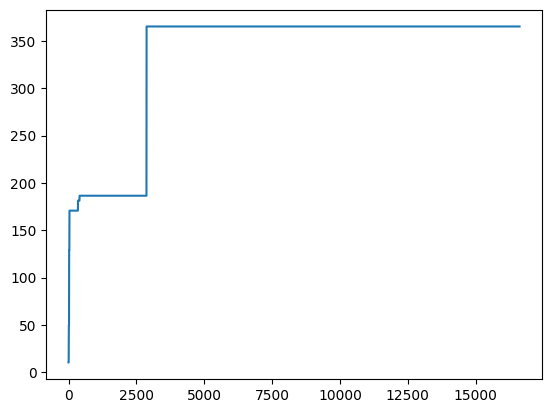

In [68]:
CoNLL= pyconll.load_from_file("corpora/English/English-EWT.conllu")
CoNLL = random.sample(CoNLL, len(CoNLL))

pqtrees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLL]
pqindex = [Profile(tree, p=2, q=2) for tree in pqtrees]


J = set(pqindex[0])
for pq_set in pqindex[1:]:
    J = J.union(pq_set)
J = list(J)

tensors = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(pqindex, desc="[convert tensor]")]
dimension = tensors[0].size()
tensors_stack = torch.stack([t.to("cuda:2") for t in tensors])


weights = torch.ones(dimension)

rad_list = []
x = list(range(1,len(tensors)))

rad = float("inf")
min_id = 1
for i in trange(1, len(tensors)):
    distances_i = w_pq.weighted_pqgram_distance_batch(weights, tensors_stack[:i], tensors_stack[i].unsqueeze(0).repeat(i, 1))
    max_distance_i = torch.max(distances_i)
    max_distance_i_arg = torch.argmax(distances_i)
    distances_min_id = w_pq.weighted_pqgram_distance_batch(weights, tensors_stack[:i], tensors_stack[min_id].unsqueeze(0).repeat(i, 1))
    max_distance_min_id = torch.max(distances_min_id)
    if max_distance_min_id != rad:
        rad = max_distance_i.item()
        min_id = i
    
    rad_list.append(rad)
    


fig, ax = plt.subplots()
ax.plot(x, rad_list)

In [9]:
CoNLL= pyconll.load_from_file("corpora/English/English-EWT.conllu")
CoNLL = random.sample(CoNLL, len(CoNLL))

pqtrees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLL]
pqindex = [Profile(tree, p=2, q=2) for tree in pqtrees]


J = set(pqindex[0])
for pq_set in pqindex[1:]:
    J = J.union(pq_set)
J = list(J)

tensors = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(pqindex, desc="[convert tensor]")]
dimension = tensors[0].size()
weights = torch.ones(dimension)
tensors_stack = torch.stack([t.to("cuda:2") for t in tensors])

[convert tensor]:   0%|          | 0/16621 [00:00<?, ?it/s]

In [ ]:
rad_list = []

dist_01 = w_pq.weighted_pqgram_distance(weights,tensors[0], tensors[1])
distance_matrix = torch.Tensor([[0,dist_01],[dist_01,0]]).to("cuda:2")
rad_list.append(calculate_radius_torch(distance_matrix))


for i in trange(2, 16621):
    new_tensor = tensors_stack[i].unsqueeze(0)
    new_distances = w_pq.weighted_pqgram_distance_batch(weights, tensors_stack[:i], new_tensor.repeat(tensors_stack[:i].size(0), 1))
    distance_matrix = add_point_to_distance_matrix(distance_matrix, new_distances)
    rad_list.append(calculate_radius_torch(distance_matrix))

rad_list

  0%|          | 0/16619 [00:00<?, ?it/s]

[28.891756057739258,
 18.385662078857422,
 18.385662078857422,
 18.385662078857422,
 18.385662078857422,
 18.385662078857422,
 15.759140014648438,
 60.4100341796875,
 60.4100341796875,
 60.4100341796875,
 91.92831420898438,
 91.92831420898438,
 91.92831420898438,
 91.92831420898438,
 76.16917419433594,
 76.16917419433594,
 76.16917419433594,
 81.42222595214844,
 81.42222595214844,
 81.42222595214844,
 81.42222595214844,
 81.42222595214844,
 81.42222595214844,
 81.42222595214844,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.54264831542969,
 73.542648315429

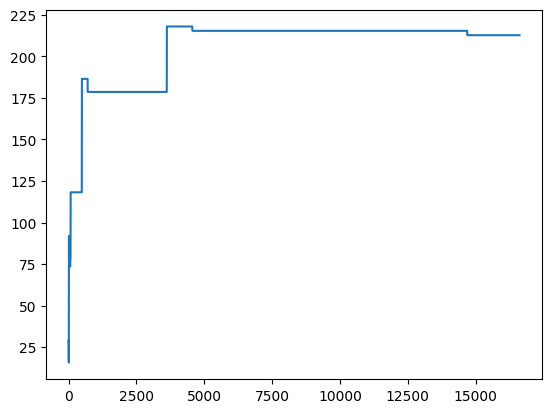

In [ ]:
x = list(range(1,len(tensors)))
fig, ax = plt.subplots()
ax.plot(x, rad_list)